This notebook maps electrode channels (the midpoint between two contacts) to hippocmapal surfaces. HippUnfold is run in space-nativepro, which is then registered to space-implant. Distances are calculated between chennel centroids and hippocampal surfaces, and all vertices within 5mm are given that channel bandpower values. 

For a more detailed explanation of code, see `notebooks/iEEG.ipynb`

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import nibabel as nib
import glob
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import pandas as pd
import scipy.io
import copy

In [5]:
micapipe_dir = '../sourcedata/Micapipe_MICs'
ieeg_dir = '../sourcedata/iEEG-BIDS' #(no ses)
ieeg_local = '../sourcedata/iEEG-local/'
hippunfold_dir = '../MICs_v1.3.0/hippunfold'
sub = glob.glob(ieeg_dir + '/sub-PX???')
for i in range(len(sub)): sub[i] = sub[i].split('/')[-1]
ses = 'ses-01'
hemi = ['L','R']
label = ['hipp','dentate'] 
ind = [range(7262), range(7262,7262+1788)]

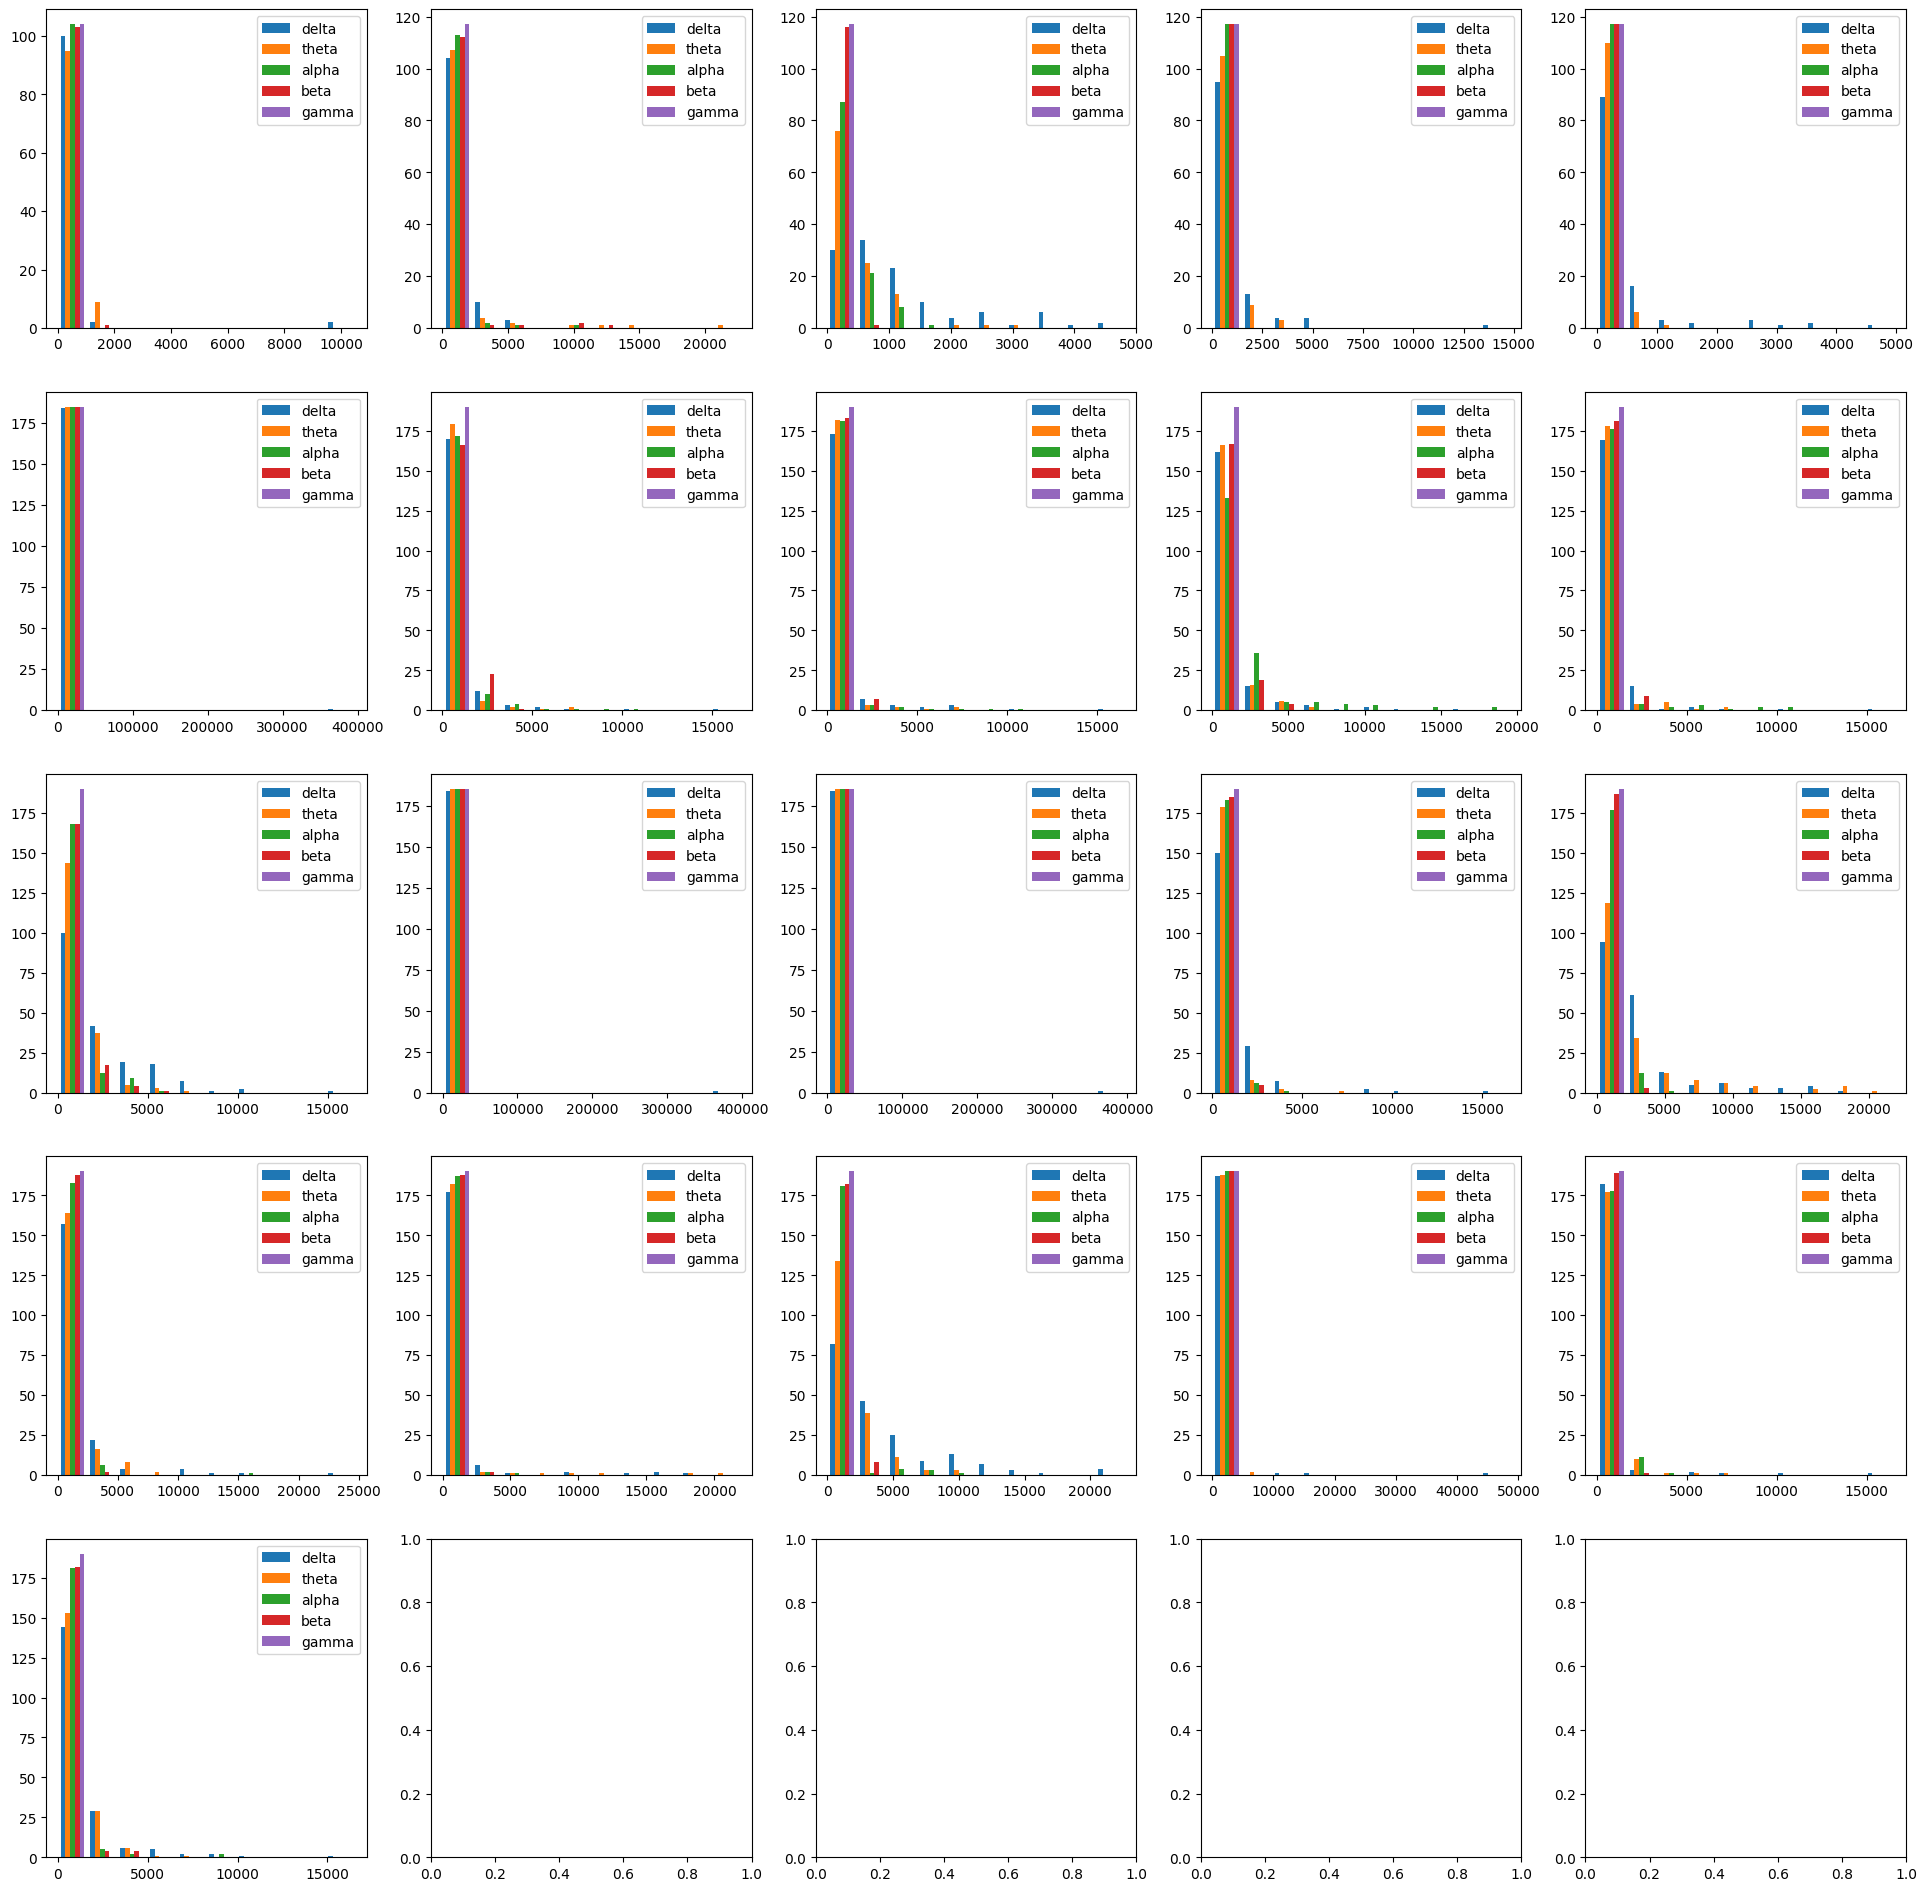

In [6]:
# look at ALL channel powers for all subjects
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(24,24))
totbp = np.zeros((0,5))
for s in range(len(sub)):
    bp = scipy.io.loadmat(f'{ieeg_local}/{sub[s]}_channelBandPower.mat')
    ax[np.unravel_index(s, ax.shape)].hist(bp['bp'][0][0]);
    ax[np.unravel_index(s, ax.shape)].legend(['delta', 'theta', 'alpha', 'beta', 'gamma'])
    totbp = np.vstack((totbp,bp['bp'][0][0]))

/tmp/ipykernel_28801/2173801371.py:16: UserWarning: Legend does not support <AxesSubplot:> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles=ax[1:])


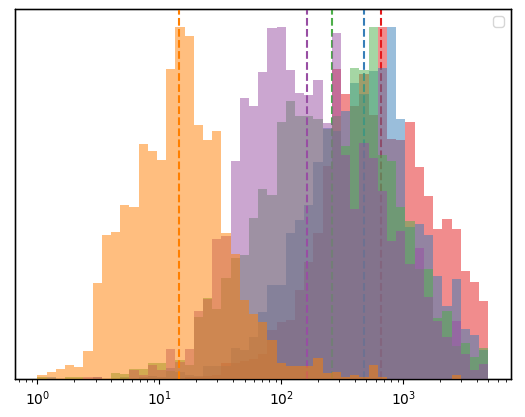

In [7]:
color_discrete = plt.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
for b in range(5):
    ax = ax + [ax[0].twinx()]
    dat = totbp[:,b]
    plt.axvline(x=np.nanmedian(dat), color=color_discrete[n], linestyle='dashed')
    ax[n+1].hist(dat,bins=np.logspace(np.log10(1),np.log10(5000), 50), linestyle=None, alpha=0.5, 
               color=color_discrete[b], label=l[b]);
    ax[n+1].yaxis.set_visible(False)
    n=n+1
plt.legend(handles=ax[1:])

In [5]:
# Register hippunfold surfaces to implant space
for s in range(len(sub)):
    cmd1 = f'antsRegistrationSyNQuick.sh -d 3 -t r '\
    f'-m {micapipe_dir}/{sub[s]}/{ses}/anat/{sub[s]}_{ses}_space-nativepro_t1w.nii.gz '\
    f'-f {ieeg_dir}/{sub[s]}/anat/{sub[s]}_implanted.nii '\
    f'-o {ieeg_dir}/{sub[s]}/xfms/{sub[s]}_{ses}_space-nativepro-to-implanted_desc-rigid_'
    if not glob.glob(f'{ieeg_dir}/{sub[s]}/xfms/{sub[s]}_{ses}_space-nativepro-to-implanted_desc-rigid_0GenericAffine.mat'):
        !{cmd1}
    cmd2 = f'c3d_affine_tool '\
        f'-itk {ieeg_dir}/{sub[s]}/xfms/{sub[s]}_{ses}_space-nativepro-to-implanted_desc-rigid_0GenericAffine.mat '\
        f'-inv '\
        f'-o {ieeg_dir}/{sub[s]}/xfms/{sub[s]}_{ses}_space-nativepro-to-implanted_desc-rigid_0GenericAffine.txt'
    if not glob.glob(f'{ieeg_dir}/{sub[s]}/xfms/{sub[s]}_{ses}_space-nativepro-to-implanted_desc-rigid_0GenericAffine.txt'):
        !{cmd2}
    for h in range(len(hemi)):
        for l in range(len(label)):    
            cmd3 = f'wb_command -surface-apply-affine '\
            f'{hippunfold_dir}/{sub[s]}/{ses}/surf/{sub[s]}_{ses}_hemi-{hemi[h]}_space-T1w_den-0p5mm_label-{label[l]}_midthickness.surf.gii '\
            f'{ieeg_dir}/{sub[s]}/xfms/{sub[s]}_{ses}_space-nativepro-to-implanted_desc-rigid_0GenericAffine.txt '\
            f'{ieeg_dir}/{sub[s]}/tmp/{sub[s]}_{ses}_hemi-{hemi[h]}_space-implant_den-0p5mm_label-{label[l]}_midthickness.surf.gii'
            if not glob.glob(f'{ieeg_dir}/{sub[s]}/tmp/{sub[s]}_{ses}_hemi-{hemi[h]}_space-implant_den-0p5mm_label-{label[l]}_midthickness.surf.gii'):
                !{cmd3}


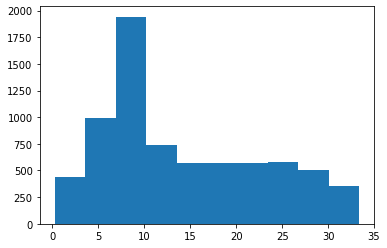

In [6]:
# view example distances from each vertex to
# the first channel from the first hippocampal electrode 
s=7
h=0
l=0
surf = nib.load(f'{ieeg_dir}/{sub[s]}/tmp/{sub[s]}_{ses}_hemi-{hemi[h]}_space-implant_den-0p5mm_label-{label[l]}_midthickness.surf.gii')
vertices = surf.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
vertices[100,:]
electrodes = glob.glob(f'{ieeg_dir}/{sub[s]}/anat/electrode_{hemi[h]}H*.csv')
e=0
df = pd.read_csv(electrodes[e],delimiter='\n',header=None, skiprows=2)
df = df[0].str.split(',', expand=True)
df = df[df[0]=='[channel]']
c=0
xyz1 = [df[3].iloc[c], df[4].iloc[c], df[5].iloc[c]]
xyz2 = [df[6].iloc[c], df[7].iloc[c], df[8].iloc[c]]
xyz = [(float(xyz1[0])+float(xyz2[0]))/2, (float(xyz1[1])+float(xyz2[1]))/2, (float(xyz1[2])+float(xyz2[2]))/2]
dists = np.zeros([len(vertices)])
for v in range(len(vertices)):
    dists[v] = np.linalg.norm(xyz-vertices[v,:])
plt.hist(dists);

In [7]:
# some upper/lower case differences etween .csv and BP.mat file formats
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

In [8]:
import re
dist_threshold = 5 #mm
dist = np.ones([7262+1788,2,totbp.shape[0]])*np.nan
hipp_dat = np.ones([7262+1788,2,5,totbp.shape[0]])*np.nan
n=-1
for s in range(len(sub)):
    # bp file is nx5. n depends how many channels were kept, so will have to look up their names in the attached dictionary. x5 is for the 5 bands
    bp = scipy.io.loadmat(f'/host/oncilla/local_raid/jessica/hippomaps/{sub[s]}_channelBandPower.mat')
    for c in range(len(bp['dataLabels_keep'])):
        n=n+1
        try:
            cname = bp['dataLabels_keep'][c][0][0].split(' ')[1]
            cnum = ''.join([i for i in cname if i.isdigit()])
            cnum = int(cnum)-2 # electrode indexing is 1:15 but channels are 1:14. need to go to 14 AND 0-index
            cname = ''.join([i for i in cname if not i.isdigit()])
            cname = insensitive_glob(f'{ieeg_dir}/{sub[s]}/anat/electrode_{cname}.csv')[0]
            df = pd.read_csv(cname,delimiter='\n',header=None, skiprows=2)
            df = df[0].str.split(',', expand=True)
            df = df[df[0]=='[channel]']
            # channel locations
            xyz1 = [df[3].iloc[cnum], df[4].iloc[cnum], df[5].iloc[cnum]]
            xyz2 = [df[6].iloc[cnum], df[7].iloc[cnum], df[8].iloc[cnum]]
            xyz = [(float(xyz1[0])+float(xyz2[0]))/2, (float(xyz1[1])+float(xyz2[1]))/2, (float(xyz1[2])+float(xyz2[2]))/2]
            for h in range(len(hemi)):
                for l in range(len(label)):
                    surf = nib.load(f'{ieeg_dir}/{sub[s]}/tmp/{sub[s]}_{ses}_hemi-{hemi[h]}_space-implant_den-0p5mm_label-{label[l]}_midthickness.surf.gii')
                    vertices = surf.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
                    for v in range(len(vertices)):
                        dist[ind[l][v],h,n] = np.linalg.norm(xyz-vertices[v,:])
                        if dist[ind[l][v],h,n] <= dist_threshold:
                            hipp_dat[ind[l][v],h,:,n] = bp['bp'][0][0][c]
        except:
            print(sub[s] + bp['dataLabels_keep'][c][0][0] + ' not found')


sub-PX023POL RCg11 not found
sub-PX023POL RCg12 not found
sub-PX023POL RCg13 not found
sub-PX023POL RCg14 not found
sub-PX023POL RCg15 not found
sub-PX028POL LHa2 not found
sub-PX028POL LHa3 not found
sub-PX028POL LHa4 not found
sub-PX028POL LHa5 not found
sub-PX028POL LHa6 not found
sub-PX028POL LHa7 not found
sub-PX028POL LHa8 not found
sub-PX028POL LHa9 not found
sub-PX028POL LHa10 not found
sub-PX028POL LHa1 not found
sub-PX029POL RPCs3 not found
sub-PX029POL RPCs4 not found
sub-PX029POL RPCs5 not found
sub-PX029POL RPCs6 not found
sub-PX019POL LT1p1 not found
sub-PX019POL LT1p2 not found
sub-PX019POL LT1p3 not found
sub-PX019POL LT1p4 not found
sub-PX019POL LT1p5 not found
sub-PX019POL LT1p6 not found
sub-PX019POL LT1p7 not found
sub-PX019POL LT1p8 not found
sub-PX019POL LT1p9 not found
sub-PX019POL LT1p10 not found
sub-PX019POL LT1p11 not found
sub-PX019POL LT1p12 not found
sub-PX019POL LT1p13 not found
sub-PX019POL LT1p14 not found
sub-PX019POL LT1p15 not found
sub-PX045POL LEC1

In [9]:
# remove outliers
threshold_bp = np.nanmedian(totbp,axis=0) + (np.nanstd(totbp,axis=0)*3)
for b in range(5):
    dat = hipp_dat[:,:,b,:]
    dat[dat>threshold_bp[b]] = np.nan
    hipp_dat[:,:,b,:] = dat
hipp_dat.shape

In [10]:
np.save('../checkpoints/iEEG_MICS.npy', [totbp,hipp_dat])

/export03/data/opt/venv/lib/python3.8/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [8]:
totbp,hipp_dat = np.load('../checkpoints/iEEG_MICS.npy', allow_pickle=True)

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


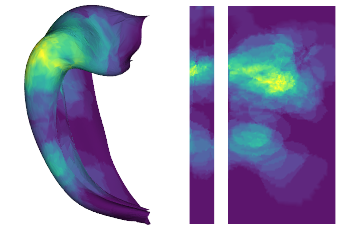

In [12]:
hipp_dat_count = np.sum(~np.isnan(hipp_dat),axis=(1,3))[:,0]
plotting.surfplot_canonical_foldunfold(hipp_dat_count, hemis=['L'], embed_nb=True)

/data/mica1/01_programs/hippunfold/ipykernel_36757/4079362135.py:16: UserWarning: Legend does not support <AxesSubplot:> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles=ax[1:])


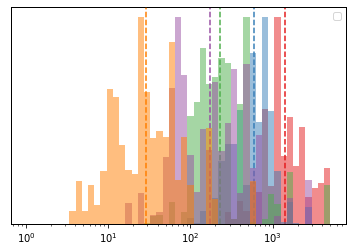

In [13]:
color_discrete = plt.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
for b in range(5):
    ax = ax + [ax[0].twinx()]
    dat = hipp_dat[:,:,b,:].flatten()
    plt.axvline(x=np.nanmedian(dat), color=color_discrete[n], linestyle='dashed')
    ax[n+1].hist(dat,bins=np.logspace(np.log10(1),np.log10(5000), 50), linestyle=None, alpha=0.5, 
               color=color_discrete[b], label=l[b]);
    ax[n+1].yaxis.set_visible(False)
    n=n+1
plt.legend(handles=ax[1:])

In [14]:
import importlib
importlib.reload(utils)
resorcesdir = '/export03/data/opt/hippunfold_toolbox/resources'
gii = nib.load(f'{resorcesdir}/canonical_surfs/tpl-avg_space-canonical_den-0p5mm_label-hipp_midthickness.surf.gii')
v = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
f = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
gii = nib.load(f'{resorcesdir}/canonical_surfs/tpl-avg_space-canonical_den-0p5mm_label-dentate_midthickness.surf.gii')
vdg = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
fdg = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
F = [f, fdg]

In [9]:
# cominbing BP across channels and vertices for visualization
# here, we exctrapoalte the data from any channel across the entire hippocampus, and then average across all channels. However, the average across channels is weighted by distance to the actual channel contact. 

weights_hipp_dat = np.ones((hipp_dat.shape[0],2,hipp_dat.shape[3]))*np.nan
interp_hipp_dat = np.zeros([hipp_dat.shape[0],5])

for h in range(2):
    for c in range(hipp_dat.shape[3]):
        dat = hipp_dat[:,h,0,c]
        for l in range(2):
            mask = ~np.isnan(dat[ind[l]])
            if np.any(mask):
                sd = utils.surf_dist(mask, F[l])
                weights_hipp_dat[ind[l],h,c] = 1 - (sd/np.max(sd))
totweights = np.nansum(weights_hipp_dat, axis=(1,2))
for v in range(weights_hipp_dat.shape[0]):
    for h in range(2):
        for c in range(hipp_dat.shape[3]):
            w = weights_hipp_dat[v,h,c] / totweights[v]
            if w>0:
                for b in range(5):
                    bp_cv = np.nanmean(hipp_dat[:,h,b,c])
                    if bp_cv>0:
                        interp_hipp_dat[v,b] = interp_hipp_dat[v,b] + (w*bp_cv)

AttributeError: module 'hippunfold_toolbox.utils' has no attribute 'surf_dist'

In [16]:
np.where(np.logical_and(np.any(weights_hipp_dat[ind[0],0,:]>0, axis=0), np.any(weights_hipp_dat[ind[1],0,:]>0, axis=0)))

(array([ 248,  249,  250,  251,  252,  263,  264,  265,  288,  289,  290,
         291,  301,  302,  303,  460,  461,  462, 1570, 1729, 1730, 1731,
        1739, 1740, 1754, 1755, 1756, 1764, 1765, 2239, 2240, 2241, 2242,
        2340, 2341, 2342]),)

In [17]:
hipp_dat.shape

(9050, 2, 5, 3597)

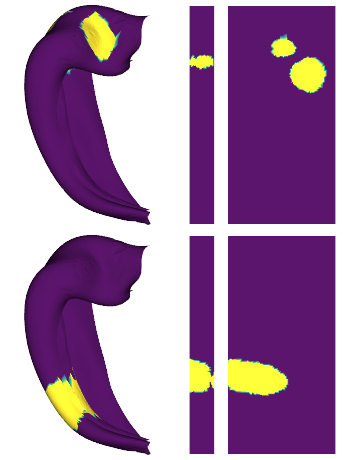

In [18]:
hd = copy.deepcopy(hipp_dat)
wd = copy.deepcopy(weights_hipp_dat)
hd[np.isnan(hd)] = 0
wd[np.isnan(wd)] = 0

h=0
c=[250,302]
plotting.surfplot_canonical_foldunfold(hd[:,h,b,c], hemis=['L'], embed_nb=True)

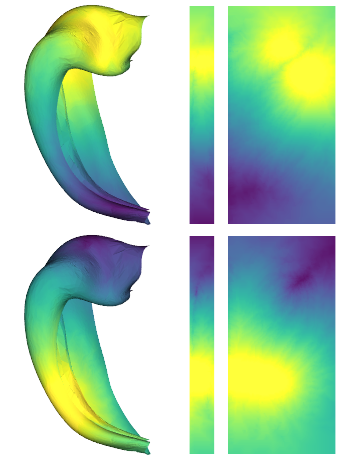

In [19]:
plotting.surfplot_canonical_foldunfold(wd[:,h,c], hemis=['L'], embed_nb=True)

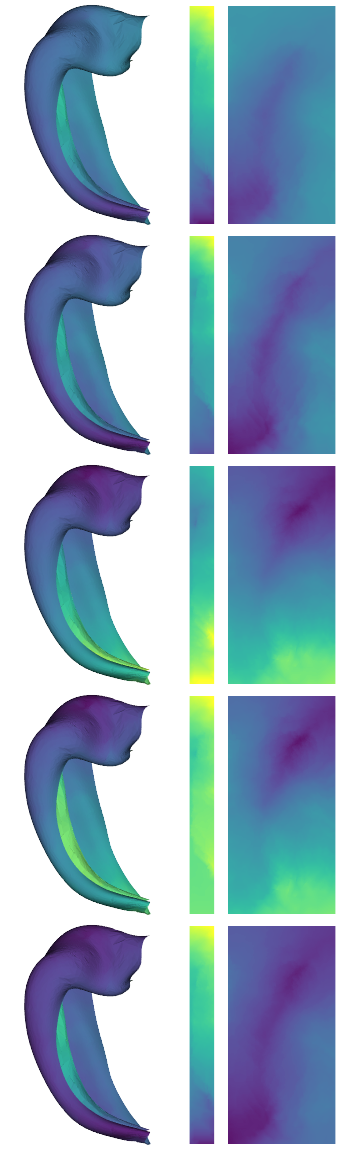

In [20]:
plotting.surfplot_canonical_foldunfold(interp_hipp_dat, hemis=['L'], embed_nb=True)

In [21]:
gii = nib.load(f'{resorcesdir}/unfold_template_hipp/tpl-avg_space-unfold_den-0p5mm_midthickness.surf.gii')
v = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
f = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
gii = nib.load(f'{resorcesdir}/unfold_template_dentate/tpl-avg_space-unfold_den-0p5mm_midthickness.surf.gii')
vdg = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
fdg = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
V = np.concatenate((v ,vdg))

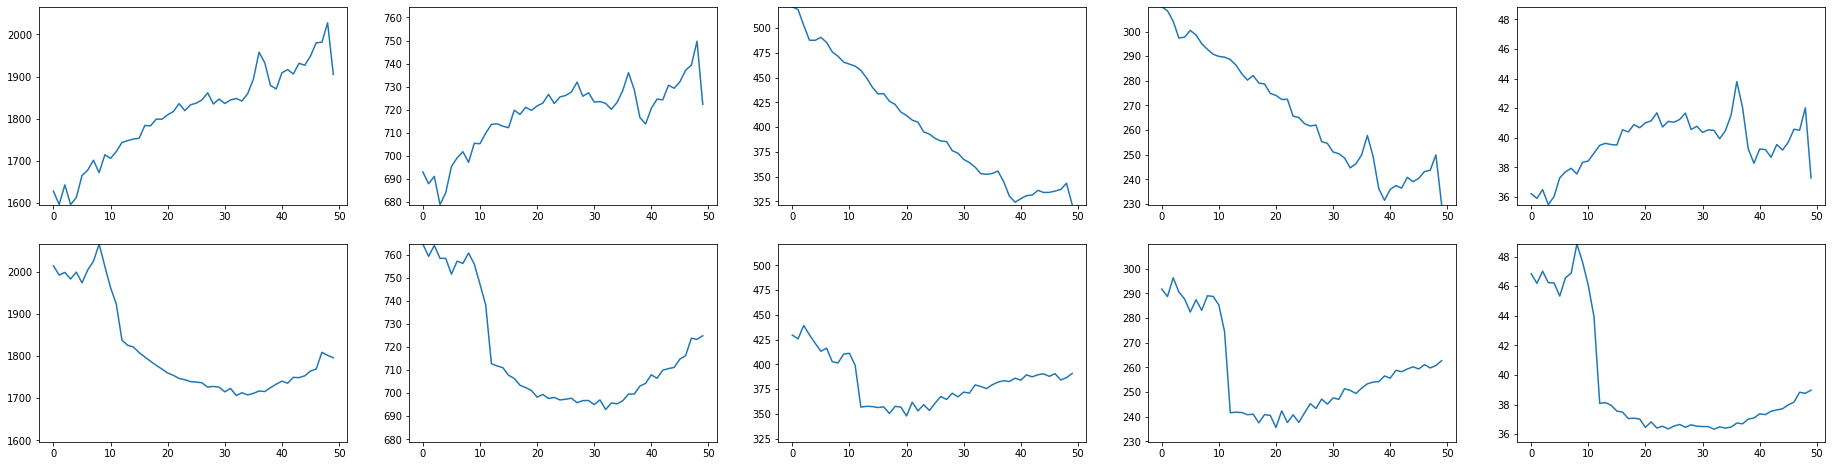

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(32,8))
                       
dAP = np.linspace(np.min(V[:,0]),np.max(V[:,0]),51)
dPD = np.linspace(np.min(V[:,1]),np.max(V[:,1]),51)

profileAP = np.ones((50,5))
profilePD = np.ones((50,5))

for i in range(len(dAP)-1):
    indAP = np.where(np.logical_and(V[:,0]>=dAP[i], V[:,0]<dAP[i+1]))[0]
    indPD = np.where(np.logical_and(V[:,1]>=dPD[i], V[:,1]<dPD[i+1]))[0]
    for b in range(5):
        profileAP[i,b] = np.mean(interp_hipp_dat[indAP,b])
        profilePD[i,b] = np.mean(interp_hipp_dat[indPD,b])

for b in range(5):
    ax[0,b].plot(profileAP[:,b])
    ax[1,b].plot(profilePD[:,b])
    
    tmp = np.concatenate((profilePD, profileAP), axis=0)
    ax[0,b].set_ylim(np.min(tmp[:,b]), np.max(tmp[:,b]))
    ax[1,b].set_ylim(np.min(tmp[:,b]), np.max(tmp[:,b]))

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


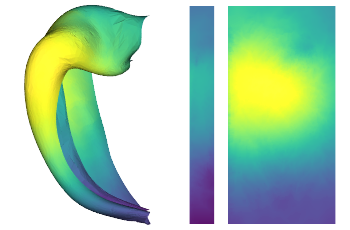

In [23]:
plotting.surfplot_canonical_foldunfold(totweights, hemis=['L'], embed_nb=True)

In [24]:
len(np.where(np.any(~np.isnan(hipp_dat[:,0,0,:]),axis=0))[0])

55

In [25]:
len(np.where(np.any(~np.isnan(hipp_dat[:,1,0,:]),axis=0))[0])

30